Brandon Ngo

The Dataset that will be used for this program was the same dataset used in the example in "image_classification_part1"

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2024-04-08 04:34:44--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.207, 142.251.12.207, 172.217.194.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  19.9MB/s    in 4.0s    

2024-04-08 04:34:48 (16.5 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
import os, signal
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


Will take the path to the train folder and set it to the variable train_dir. It will also set both the directories of the cats and dogs.

In [3]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

Output for the amount of images in the train folder for both dogs and cats

In [4]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))

total training cat images: 1000
total training dog images: 1000


The model that we will be using is the efficientnet_v2 with the image size of 512x512 and a batch size of 16

In [5]:
model_handle = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2"

IMAGE_SIZE = (512, 512)

BATCH_SIZE = 16

This part of the code will do random translations, rotations, zooms, and flips on the images. It will also take the size of the training folder, 2000 (1000 dogs, 1000 cats), and set 20% to the validation set

In [6]:
import tensorflow as tf
import tensorflow_hub as hub
def build_dataset(subset):
  return tf.keras.preprocessing.image_dataset_from_directory(
      train_dir,
      validation_split=.20,
      subset=subset,
      label_mode="categorical",
      seed=27,
      image_size=IMAGE_SIZE,
      batch_size=1)

train_ds = build_dataset("training")
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()

normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = False
if do_data_augmentation:
  preprocessing_model.add(
      tf.keras.layers.RandomRotation(40))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0.2, 0))
  # Like the old tf.keras.preprocessing.image.ImageDataGenerator(),
  # image sizes are fixed when reading, and then a random zoom is applied.
  # If all training inputs are larger than image_size, one could also use
  # RandomCrop with a batch size of 1 and rebatch later.
  preprocessing_model.add(
      tf.keras.layers.RandomZoom(0.2, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomFlip(mode="horizontal"))
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))

val_ds = build_dataset("validation")
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

Found 2000 files belonging to 2 classes.
Using 1600 files for training.
Found 2000 files belonging to 2 classes.
Using 400 files for validation.


Fine tuning to false since we will be adding on to a model

In [7]:
do_fine_tuning = False

This here will build our model with efficientnet_v2, a dropout layer and a dense layer. The dropout layer will help with overfitting and the dense layer will classify the output. The dropout rate @ 0.2 so the model can learn more imporatant features and the low regulairizer for the weight.


In [8]:
print("Building model with", model_handle)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              20331360  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 20333922 (77.57 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 20331360 (77.56 MB)
_________________________________________________________________


Since we are working with computer vision on images we will be using accuracy as out main parameter.

In [9]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

The model ran with 3 epoch, there were 2 reasons for the low number. The first is that the model reconized images at a very high accuracy, the other reason was that I don't have Premuium Colab and it would tell me I need to upgrade to unlock GPU.

In [10]:
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
hist = model.fit(
    train_ds,
    epochs=3, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps).history

Epoch 1/3
100/100 [==============================] - 59s 413ms/step - loss: 0.2747 - accuracy: 0.9669 - val_loss: 0.2239 - val_accuracy: 0.9975
Epoch 2/3
100/100 [==============================] - 38s 381ms/step - loss: 0.2228 - accuracy: 0.9969 - val_loss: 0.2178 - val_accuracy: 0.9975
Epoch 3/3
100/100 [==============================] - 38s 376ms/step - loss: 0.2180 - accuracy: 0.9981 - val_loss: 0.2150 - val_accuracy: 1.0000


With the results we can see a very accurate model being used for this dataset. With a large non-trainable params of +20 million, transfer learning shows its positives. Accuracy levels are 98%+ avg means unlikely events of classifying the image wrong.

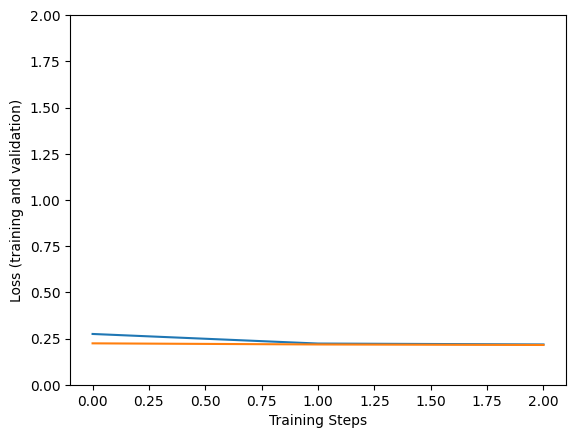

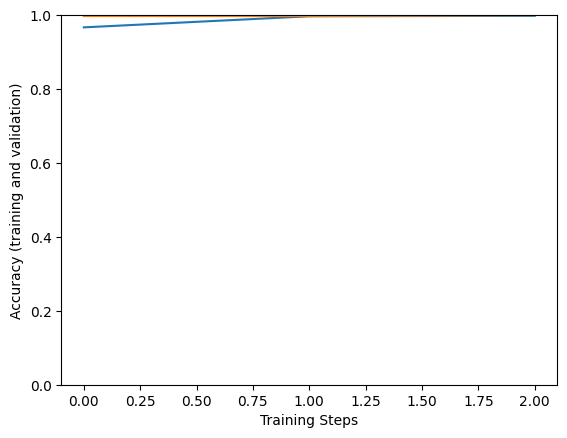

In [11]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

The tranfer learning model that was used allowed for a high percent of accuracy. Some improvesments can come with adding in different animals, or having the model trying to learn different breeds of cats and dogs.

In [ ]:
os.kill(os.getpid(), signal.SIGKILL)